# ECS171 Final Group Project: Pizza/Not Pizza Image Classifier


## Step 1: Data Exploration
Goals for this portion of the project:
+ Data evaluation
    + Evaluate all of the photos in the dataset, cull outliers
+ Number of total observations
    + Number and list of classes, plot class data
+ Image specifications
    + Total number of images
    + Image dimensions, and whether they need to be processed to be standardized

Preliminary data evaluation:
- The pizza directory also includes images of primarily people eating pizza (and one singular photo of a baby), and not the actual food itself; they've been culled before we imported the data.
- Data cannot be downloaded from Kaggle without an account; the data has been downloaded and stored in the GitHub repo instead to simplify the process of importing the repo and directly using this notebook, at the cost of storage space (however, the data is only ~100 MB unpacked).

In [65]:
# Library imports
# The standard ones.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Use the built-in Keras utility for image imports
# Based on the docs, this will infer class type from directory structure.
from keras.utils import image_dataset_from_directory

Found 1962 files belonging to 2 classes.


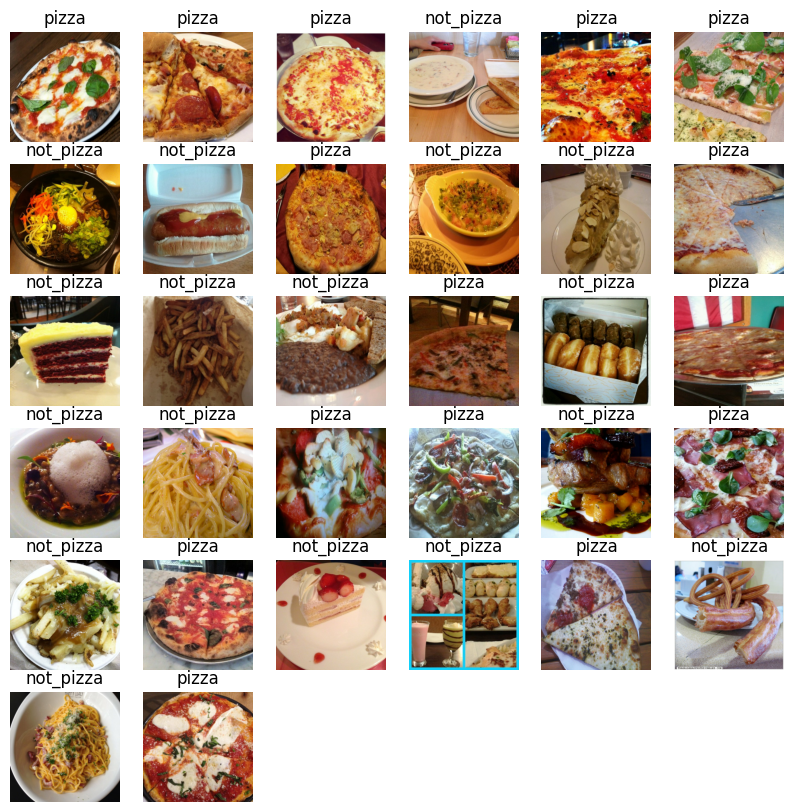

In [ ]:
# From the data directory, import the images with binary numeric labels and convert to RGB (f not already)
data = image_dataset_from_directory("pizza_not_pizza", labels='inferred', label_mode='binary', color_mode='rgb')

# Following code is modified from https://www.tensorflow.org/tutorials/load_data/images#visualize_the_data
plt.figure(figsize=(10, 10))
class_names = data.class_names
for images, labels in data.take(1):
    for i in range(32): # Batch size is default of 32
        ax = plt.subplot(6, 6, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.array(labels[i])[0])])
        plt.axis("off")

Members of not_pizza: 983
Members of pizza: 979
Total # of classes: 2


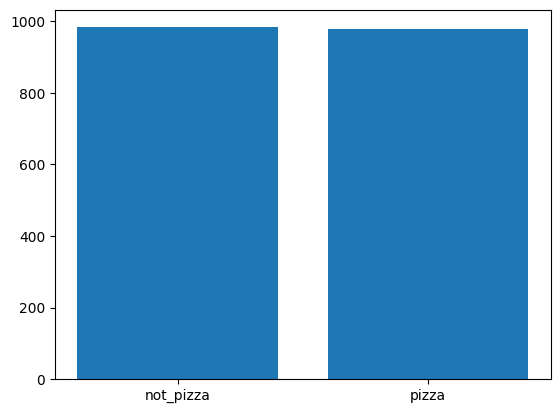

In [ ]:
# Per the documents, there doesn't seem to be an easy way to get # of images per class from the dataset.
# Therefore, we can just do it ourselves the hard way — this solution assumes the OS library cannot be used.

plotLabel = [0, 0] # Not pizza, pizza
# Get all the file paths
fp = np.array(data.file_paths)
# Cull the parent directory from each string
fp = [i[16:] for i in fp]
for i in range(len(fp)):
    if fp[i].find("not_pizza") != -1:
        plotLabel[0] += 1
    else:
        plotLabel[1] += 1

plt.bar(class_names, plotLabel)
print("Members of " + class_names[0] + ": " + str(plotLabel[0]))
print("Members of " + class_names[1] + ": " + str(plotLabel[1]))
print("Total # of classes: " + str(len(class_names)))

# Image specifications
- Per the original dataset, there were 983 images of both pizza and non-pizza, meaning that the original set had a total of 1,966 photos. After our outlier check, there are now only 979 images of pizza, meaning we're currently working with 1,962 images. Furthermore, all provided photos have been resized such that one dimension of either width or height is 512 pixels, but wildly vary in the other dimension; the most consistent aspect ratio being square 1:1 photos. In this case, we can either choose to keep Keras' perservation of the full image with aspect ratio distortion, or enable cropping of the photo on import.

# Step2: First Model

In [16]:
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *


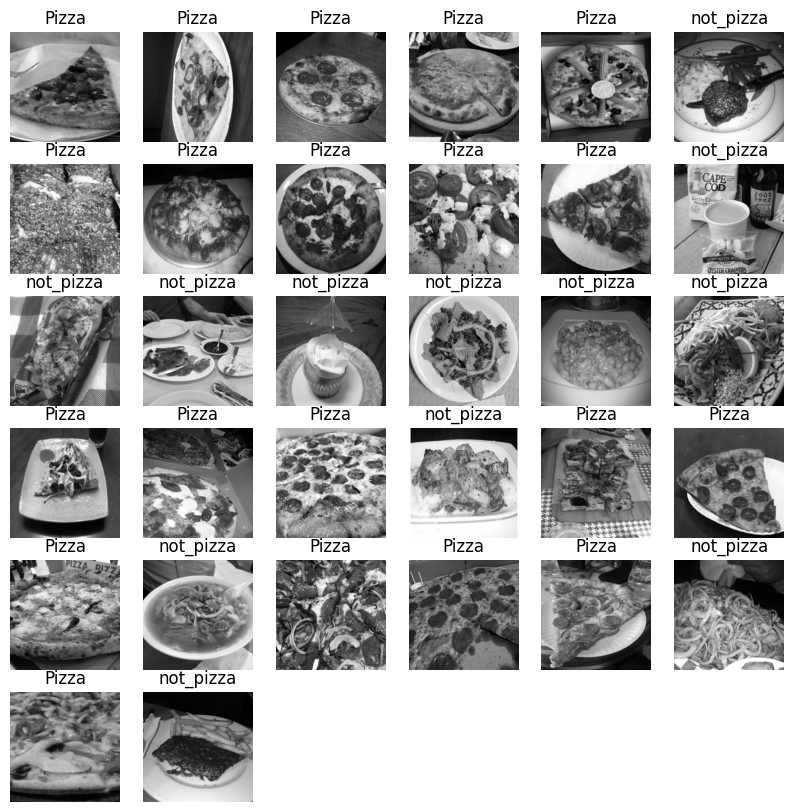

In [10]:
# Filepaths for the pizza and pasta images
fpath_pizza = "./pizza_not_pizza/pizza/"
fpath_notpizza = "./pizza_not_pizza/not_pizza/"
pizza_files = [fpath_pizza + file for file in os.listdir(fpath_pizza)]
notpizza_files = [fpath_notpizza + file for file in os.listdir(fpath_notpizza)]

# Construct pandas dataframe
df_pizza = pd.DataFrame()
df_pizza["filepath"] = pizza_files
df_pizza["label"] = np.zeros(len(pizza_files))

df_notpizza = pd.DataFrame()
df_notpizza["filepath"] = notpizza_files
df_notpizza["label"] = np.ones(len(notpizza_files))

df_data = pd.concat([df_pizza, df_notpizza])

#function to load images
#convert to grayscale(float between 0-1) images and resize to 128x128(default)
def load_images(filepath, size = (256, 256)):
    return np.asarray(Image.open(filepath).resize(size).convert('L')) / 255.0

# #add col to datafram(containing list object)
# df_data["img"] = df_data["filepath"].apply(lambda x: load_images(x))

#split data into two df
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)



#plot examples
fig = plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(6, 6, i+1)
    img = load_images(df_train["filepath"][i])
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if df_train["label"][i] == 0:
        plt.title("Pizza")
    else:
        plt.title("not_pizza")
plt.show()


In [11]:
df_data

,filepath,label
0,./pizza_not_pizza/pizza/1001116.jpg,0.0
1,./pizza_not_pizza/pizza/1008104.jpg,0.0
2,./pizza_not_pizza/pizza/1008144.jpg,0.0
3,./pizza_not_pizza/pizza/1008844.jpg,0.0
4,./pizza_not_pizza/pizza/1008941.jpg,0.0
...,...,...
978,./pizza_not_pizza/not_pizza/987958.jpg,1.0
979,./pizza_not_pizza/not_pizza/988368.jpg,1.0
980,./pizza_not_pizza/not_pizza/99088.jpg,1.0
981,./pizza_not_pizza/not_pizza/996485.jpg,1.0


In [18]:
#model
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(
  optimizer = keras.optimizers.Adam(),
  loss = keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])


In [19]:
# Create X_train, X_test, y_train, y_test
X_train = np.empty([df_train.shape[0], 256, 256])
for index, row in df_train.iterrows():
    img = load_images(row.filepath)
    X_train[index] = img
    
X_test = np.empty([df_test.shape[0], 256, 256])
for index, row in df_test.iterrows():
    img = load_images(row.filepath)
    X_test[index] = img

y_train = df_train["label"].to_numpy()
y_test = df_test["label"].to_numpy()

In [21]:
#train model
model.fit(X_train, y_train, epochs = 10, verbose = 1)

Epoch 1/10
50/50 [==============================] - 23s 451ms/step - loss: 0.0385 - accuracy: 0.9994
Epoch 2/10
50/50 [==============================] - 22s 434ms/step - loss: 0.0380 - accuracy: 0.9962
Epoch 3/10
50/50 [==============================] - 22s 433ms/step - loss: 0.0193 - accuracy: 1.0000
Epoch 4/10
50/50 [==============================] - 22s 434ms/step - loss: 0.0155 - accuracy: 0.9994
Epoch 5/10
50/50 [==============================] - 23s 461ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 6/10
50/50 [==============================] - 24s 473ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 7/10
50/50 [==============================] - 22s 446ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 8/10
50/50 [==============================] - 23s 464ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 9/10
50/50 [==============================] - 25s 503ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 10/10
50/50 [==============================] - 23s 465ms/step - loss: 0.0043 - accura

# training value

50/50 [==============================] - 6s 110ms/step
              precision    recall  f1-score   support

   Not Pizza       1.00      1.00      1.00       794
       Pizza       1.00      1.00      1.00       775

    accuracy                           1.00      1569
   macro avg       1.00      1.00      1.00      1569
weighted avg       1.00      1.00      1.00      1569



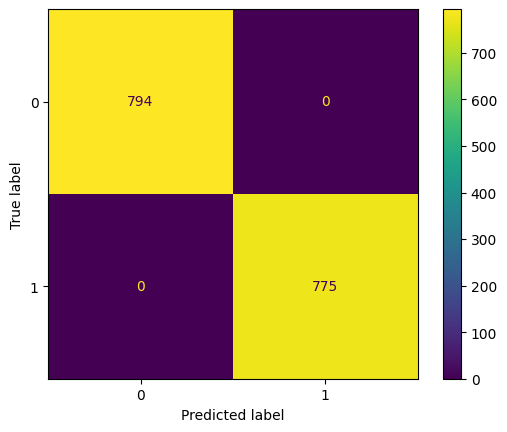

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_hat_train = model.predict(X_train)
y_hat_train = [ 1 if y>=0.5 else 0 for y in y_hat_train ]
print(classification_report(y_train, y_hat_train, target_names = ["Not Pizza", "Pizza"]))

cm2 = confusion_matrix(y_train, y_hat_train)
cm_display2 = ConfusionMatrixDisplay(cm2).plot()

# testing value

13/13 [==============================] - 1s 109ms/step
              precision    recall  f1-score   support

   Not Pizza       0.67      0.82      0.74       185
       Pizza       0.80      0.64      0.71       208

    accuracy                           0.73       393
   macro avg       0.74      0.73      0.72       393
weighted avg       0.74      0.73      0.72       393



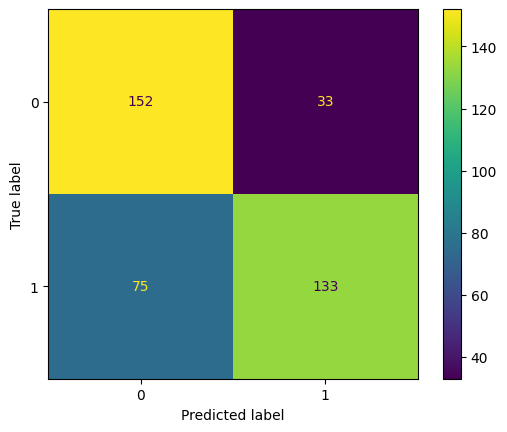

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_hat = model.predict(X_test)
y_hat = [ 1 if y>=0.5 else 0 for y in y_hat ]
print(classification_report(y_test, y_hat, target_names = ["Not Pizza", "Pizza"]))

cm2 = confusion_matrix(y_test, y_hat)
cm_display2 = ConfusionMatrixDisplay(cm2).plot()